In [1]:
from Initialization_multi_element import *

c:\libs\pycqed_py3\data
Data directory set to: c:\libs\pycqed_py3\data
c:\libs\pycqed_py3\data
Connected to: None AWG_ATS (serial:None, firmware:None) in 1.10s
Connected to: Agilent Technologies N5183B (serial:MY53271678, firmware:B.01.60) in 0.04s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/101645, firmware:3.1.19.15-3.50.124.67) in 0.03s


c:\libs\qcodes\qcodes\instrument\parameter.py:247: UserWarning:

Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.

Snapshot: Could not update parameter: clock_source on ATS
Snapshot: Could not update parameter: sample_rate on ATS
Snapshot: Could not update parameter: clock_edge on ATS
Snapshot: Could not update parameter: decimation on ATS
Snapshot: Could not update parameter: coupling1 on ATS
Snapshot: Could not update parameter: channel_range1 on ATS
Snapshot: Could not update parameter: impedance1 on ATS
Snapshot: Could not update parameter: bwlimit1 on ATS
Snapshot: Could not update parameter: coupling2 on ATS
Snapshot: Could not update parameter: channel_range2 on ATS
Snapshot: Could not update parameter: impedance2 on ATS
Snapshot: Could not update parameter: bwlimit2 on ATS
Snapshot: Could not update parameter: trigger_operation on ATS
Snapshot: Could not update parameter: trigger_engine1 on A

controller initialized


In [2]:
station.components

{'RFLO': <N51x1: RFLO>,
 'SPEC': <RohdeSchwarz_SGS100A: SPEC>,
 'ATS': <AlazarTech_ATS9870: ATS>,
 'ATS_controller_multi_element': <Demodulation_AcquisitionController: ATS_controller_multi_element>,
 'HS': <HeterodyneInstrument: HS>,
 'MC': <MeasurementControl: MC>}

In [3]:
RFLO.on()

In [4]:
SPEC.power(-5)
SPEC.IQ_state('ON')  
SPEC.frequency(6.16e9-0.05e9)
SPEC.off()

In [5]:
RFLO.power(13.0)
RFLO.frequency(6.16e9)

In [6]:
RFLO.power()

13.0

In [7]:
ATS.config(clock_source='INTERNAL_CLOCK',
                sample_rate=1e9,
                clock_edge='CLOCK_EDGE_RISING',
                decimation=0,
                coupling=['DC','DC'],
                channel_range=[0.1,0.1],
                impedance=[50,50],
                bwlimit=['DISABLED','DISABLED'],
                trigger_operation='TRIG_ENGINE_OP_J',
                trigger_engine1='TRIG_ENGINE_J',
                trigger_source1='EXTERNAL',
                trigger_slope1='TRIG_SLOPE_POSITIVE',
                trigger_level1=128,
                trigger_engine2='TRIG_ENGINE_K',
                trigger_source2='DISABLE',
                trigger_slope2='TRIG_SLOPE_POSITIVE',
                trigger_level2=128,
                external_trigger_coupling='DC',
                external_trigger_range='ETR_1V',
                trigger_delay=0,
                timeout_ticks=0
)

In [8]:
# configure the ATS controller
ATS_controller.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=4096,
                 records_per_buffer=21*300,#number of elements x average per acquisition
                 buffers_per_acquisition=5,
                 channel_selection='AB',
                 transfer_offset=0,
                 external_startcapture='ENABLED',
                 enable_record_headers='DISABLED',
                 alloc_buffers='DISABLED',
                 fifo_only_streaming='DISABLED',
                 interleave_samples='DISABLED',
                 get_processed_data='DISABLED',
                 allocated_buffers=5,  
                 buffer_timeout=5000,
)


In [544]:
%matplotlib inline

In [9]:
def ATS_homodyne_acquisition_multielements(integration_start, integration_time, Numer_of_elements, Numer_of_avg):

    integration_end = integration_start + integration_time
    ATS.external_trigger_coupling._set_updated()
    ATS.external_trigger_range._set_updated()
    
    ATS_controller.pre_acquire()
    blub = ATS_controller.do_acquisition()
    ATS_controller.post_acquire()

    buffer = ATS_controller.buffer
    reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer() , ATS.samples_per_record())/ATS.allocated_buffers()-128.


# print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[-50:]])
# print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[:50]])

    for i in range(Numer_of_elements):
        average_record_I[i] = np.average(reshaped_buffer[0][i::Numer_of_elements], axis = 0)
        average_record_Q[i] = np.average(reshaped_buffer[1][i::Numer_of_elements], axis = 0)


    offset_I=np.zeros(Numer_of_elements)
    offset_Q=np.zeros(Numer_of_elements)
    integrated_output_I=np.zeros(Numer_of_elements)
    integrated_output_Q=np.zeros(Numer_of_elements)

    
    for i in range(Numer_of_elements):
        offset_I[i] = np.average(average_record_I[i][3000:4000])
        offset_Q[i] = np.average(average_record_Q[i][3000:4000])
        integrated_output_I[i] = np.average(average_record_I[i][integration_start:integration_end])-offset_I[i]#/range_I
        integrated_output_Q[i] = np.average(average_record_Q[i][integration_start:integration_end])-offset_Q[i]#/range_Q
      
    
#     range_I = np.max(average_record_I[integration_start:integration_end]) \
#              -np.min(average_record_I[integration_start:integration_end])
   
#     range_Q = np.max(average_record_Q[integration_start:integration_end]) \
#              -np.min(average_record_Q[integration_start:integration_end])
    
    return [integrated_output_I, integrated_output_Q]

In [10]:
def ATS_homodyne_acquisition(integration_start, integration_time):
    
    integration_end = integration_start + integration_time
    ATS.external_trigger_coupling._set_updated()
    ATS.external_trigger_range._set_updated()
    
    ATS_controller.pre_acquire()
    blub = ATS_controller.do_acquisition()
    ATS_controller.post_acquire()

    buffer = ATS_controller.buffer
    reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer(), ATS.samples_per_record())/ATS.buffers_per_acquisition()

#     print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[-50:]])
#     print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[:50]])

    average_record_I = np.average(reshaped_buffer[0,:,:], axis = 0)-128.
    average_record_Q = np.average(reshaped_buffer[1,:,:], axis = 0)-128.
    
    offset_I = np.average(average_record_I[3000:4000])
    offset_Q = np.average(average_record_Q[3000:4000])
    
#     range_I = np.max(average_record_I[integration_start:integration_end]) \
#              -np.min(average_record_I[integration_start:integration_end])
   
#     range_Q = np.max(average_record_Q[integration_start:integration_end]) \
#              -np.min(average_record_Q[integration_start:integration_end])
    
#     integrated_output_I = np.average(average_record_I[integration_start:integration_end])#/range_I
#     integrated_output_Q = np.average(average_record_Q[integration_start:integration_end])#/range_Q
    
    
    integrated_output_I = np.average(average_record_I[integration_start:integration_end]-offset_I)#/range_I
    integrated_output_Q = np.average(average_record_Q[integration_start:integration_end]-offset_Q)#/range_Q
    
    return [integrated_output_I, integrated_output_Q, offset_I, offset_Q]

In [11]:
integration_start=674
integration_end=integration_start+1000

RFLO.frequency(6.157e9)
SPEC.frequency(6.157e9+0.05e9)
SPEC.power(0)
SPEC.off()
ATS.external_trigger_coupling._set_updated()
ATS.external_trigger_range._set_updated()
RFLO.on()
Numer_of_elements = 21
Numer_of_avg = 300

ATS_controller.awgcontrol(amp=1.0,seq='rabi_sequence_amp_scan_FILE.seq')

ATS_controller.pre_acquire()
ATS_controller.do_acquisition()
ATS_controller.post_acquire()

buffer = ATS_controller.buffer
reshaped_buffer = buffer.reshape(2, Numer_of_avg, Numer_of_elements , ATS.samples_per_record())/ATS.allocated_buffers()-128.

# print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[-50:]])
# print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[:50]])

offset_I=np.zeros(Numer_of_elements)
offset_Q=np.zeros(Numer_of_elements)
integrated_output_I=np.zeros(Numer_of_elements)
integrated_output_Q=np.zeros(Numer_of_elements)

for i in range(Numer_of_elements):
    average_record_I = np.average(reshaped_buffer[0][:,:,:], axis = 0)
    average_record_Q = np.average(reshaped_buffer[1][:,:,:], axis = 0)

    
for i in range(Numer_of_elements):
    offset_I[i] = np.average(average_record_I[i][3000:4000])
    offset_Q[i] = np.average(average_record_Q[i][3000:4000])
    integrated_output_I[i] = np.average(average_record_I[i][integration_start:integration_end])-offset_I[i]#/range_I
    integrated_output_Q[i] = np.average(average_record_Q[i][integration_start:integration_end])-offset_Q[i]#/range_Q


# integrated_output_power = np.average((average_record_I[integration_start:integration_end]
#                                      +average_record_Q[integration_start:integration_end])**2)
# integrated_output_power = np.average(((average_record_I[integration_start:integration_end])**2
#                                      +(average_record_Q[integration_start:integration_end])**2))**0.5

print(integrated_output_I[2])
print(integrated_output_Q[2])


plt.figure(figsize=(10,10))
plt.plot(average_record_I[0])
plt.plot(average_record_Q[0])
plt.xlim(0, 4000)

plt.figure(figsize=(10,10))
plt.plot(average_record_I[10])
plt.plot(average_record_Q[10])
plt.xlim(0, 4000)

plt.figure(figsize=(10,10))
plt.plot(average_record_I[20])
plt.plot(average_record_Q[20])
plt.xlim(0, 4000)

RuntimeError: error 579: ApiWaitTimeout: operation did not finish during timeout interval. Check your trigger. from function AlazarWaitAsyncBufferComplete with args: [3952, 385024000, 5000]

# Multi-element Rabi

In [114]:
ATS_controller.awgcontrol(amp=0.2,seq='rabi_sequence_int_scan_FILE.seq')

In [27]:
#single buffer measurement.2019.03.22.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=700
integration_time=500

rabi_integrated_output_I = np.zeros((Numer_of_elements))
rabi_integrated_output_Q = np.zeros((Numer_of_elements))

SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9+0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=500

for ii in range(0,length):
    print(ii)
    ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
    for i in range(0,Numer_of_elements):
        rabi_integrated_output_I[i]=rabi_integrated_output_I[i]+ATS_Tempo[0][i]
        rabi_integrated_output_Q[i]=rabi_integrated_output_Q[i]+ATS_Tempo[1][i]

rabi_integrated_output_I = rabi_integrated_output_I/length
rabi_integrated_output_Q = rabi_integrated_output_Q/length



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [89]:
pulse_length=[  1.00000000e-08,   2.50000000e-08,   4.00000000e-08,
         5.50000000e-08,   7.00000000e-08,   8.50000000e-08,
         1.00000000e-07,   1.15000000e-07,   1.30000000e-07,
         1.45000000e-07,   1.60000000e-07,   1.75000000e-07,
         1.90000000e-07,   2.05000000e-07,   2.20000000e-07,
         2.35000000e-07,   2.50000000e-07,   2.65000000e-07,
         2.80000000e-07,   2.95000000e-07,   3.10000000e-07]

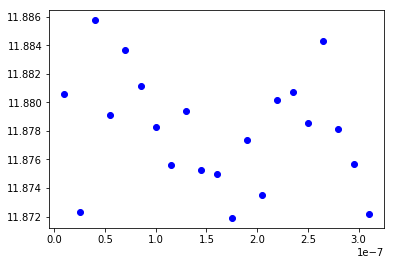

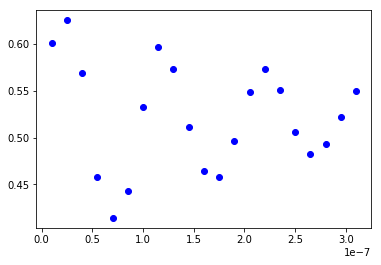

In [28]:
plt.figure()
plt.plot(pulse_length, rabi_integrated_output_I,'bo')
plt.figure()
plt.plot(pulse_length, rabi_integrated_output_Q,'bo')

In [29]:
rabi_integrated_output_I

array([ 11.88058747,  11.87231293,  11.88575287,  11.87912701,
        11.88368916,  11.88112347,  11.87828371,  11.87558318,
        11.87936717,  11.87523471,  11.87499473,  11.87190403,
        11.87738395,  11.87352483,  11.88018177,  11.88072068,
        11.87855523,  11.8843324 ,  11.87816286,  11.87570898,  11.87215605])

In [30]:
rabi_integrated_output_Q

array([ 0.60085391,  0.62546013,  0.56861989,  0.45774961,  0.41403289,
        0.44270767,  0.53248467,  0.59661565,  0.57331575,  0.51149538,
        0.46402871,  0.45825832,  0.49646761,  0.54880967,  0.5735068 ,
        0.5510191 ,  0.50547916,  0.48244098,  0.49349065,  0.52183832,
        0.54977971])

In [106]:
#5-buffer measurement.2019.03.22.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=800
integration_time=500

rabi_integrated_output_I2 = np.zeros((Numer_of_elements))
rabi_integrated_output_Q2 = np.zeros((Numer_of_elements))

SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9+0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=100

for ii in range(0,length):
    print(ii)
    ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
    for i in range(0,Numer_of_elements):
        rabi_integrated_output_I2[i]=rabi_integrated_output_I2[i]+ATS_Tempo[0][i]
        rabi_integrated_output_Q2[i]=rabi_integrated_output_Q2[i]+ATS_Tempo[1][i]

rabi_integrated_output_I2 = rabi_integrated_output_I2/length
rabi_integrated_output_Q2 = rabi_integrated_output_Q2/length



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


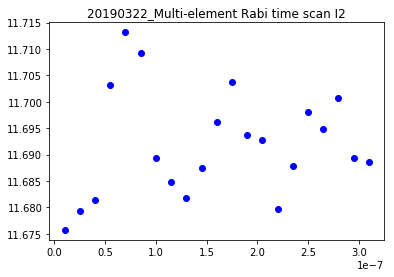

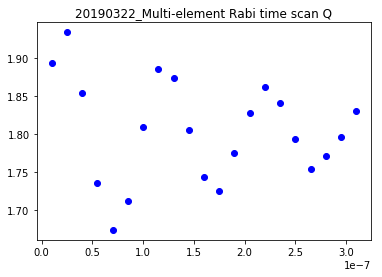

In [107]:
plt.figure()
plt.title('20190322_Multi-element Rabi time scan I2')
plt.plot(pulse_length, rabi_integrated_output_I2,'bo')
plt.figure()
plt.title('20190322_Multi-element Rabi time scan Q2')
plt.plot(pulse_length, rabi_integrated_output_Q2,'bo')

In [109]:
print(rabi_integrated_output_I2)
print(rabi_integrated_output_Q2)

[ 11.67574     11.679273    11.68138382  11.70327243  11.71317225
  11.70924583  11.68926744  11.68479721  11.68170383  11.68747833
  11.69620335  11.70372773  11.69368131  11.69274288  11.67969062
  11.68785313  11.69810813  11.69485342  11.70067363  11.68941753
  11.68862171]
[ 1.89375797  1.93348939  1.85342919  1.73596756  1.67395943  1.71140721
  1.8085926   1.88461585  1.87323149  1.80517986  1.74296287  1.72453025
  1.77448213  1.82741099  1.86174323  1.84010442  1.79296637  1.75438109
  1.77043476  1.79656349  1.83018696]


In [116]:
#5-buffer measurement.2019.03.22.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=800
integration_time=500

rabi_integrated_output_I3 = np.zeros((Numer_of_elements))
rabi_integrated_output_Q3 = np.zeros((Numer_of_elements))

SPEC.power.set(-16.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9+0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=50

for ii in range(0,length):
    print(ii)
    ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
    for i in range(0,Numer_of_elements):
        rabi_integrated_output_I3[i]=rabi_integrated_output_I3[i]+ATS_Tempo[0][i]
        rabi_integrated_output_Q3[i]=rabi_integrated_output_Q3[i]+ATS_Tempo[1][i]

rabi_integrated_output_I3 = rabi_integrated_output_I3/length
rabi_integrated_output_Q3 = rabi_integrated_output_Q3/length


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


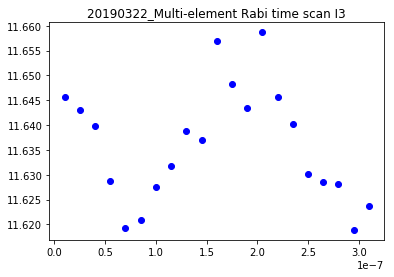

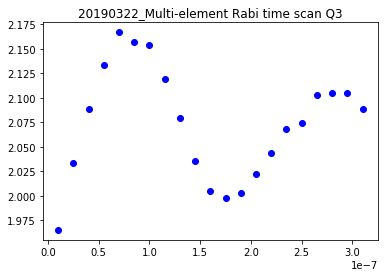

In [117]:
plt.figure()
plt.title('20190322_Multi-element Rabi time scan I3')
plt.plot(pulse_length, rabi_integrated_output_I3,'bo')
plt.figure()
plt.title('20190322_Multi-element Rabi time scan Q3')
plt.plot(pulse_length, rabi_integrated_output_Q3,'bo')

In [175]:
print(rabi_integrated_output_I3)
print(rabi_integrated_output_Q3)

[ 11.64574224  11.64308917  11.63984739  11.62863923  11.61924155
  11.62094637  11.62759381  11.63184653  11.63888939  11.63706351
  11.65689879  11.64824892  11.64347031  11.65869331  11.64558775
  11.64019516  11.63018651  11.62848719  11.62808641  11.61887741
  11.62359457]
[ 1.96529983  2.03324627  2.08901425  2.13315123  2.16700355  2.15724193
  2.15375069  2.11904677  2.07986187  2.03576024  2.00513077  1.99737425
  2.00295039  2.02275401  2.04383923  2.06865864  2.07478465  2.10250471
  2.10486975  2.10452967  2.08862632]


In [195]:
#5-buffer measurement.2019.03.23.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=800
integration_time=500

rabi_integrated_output_I4 = np.zeros((Numer_of_elements))
rabi_integrated_output_Q4 = np.zeros((Numer_of_elements))

SPEC.power.set(-16.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9+0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.15805e9)  
length=100

for ii in range(0,length):
    print(ii)
    ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
    for i in range(0,Numer_of_elements):
        rabi_integrated_output_I4[i]=rabi_integrated_output_I4[i]+ATS_Tempo[0][i]
        rabi_integrated_output_Q4[i]=rabi_integrated_output_Q4[i]+ATS_Tempo[1][i]

rabi_integrated_output_I4 = rabi_integrated_output_I4/length
rabi_integrated_output_Q4 = rabi_integrated_output_Q4/length

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


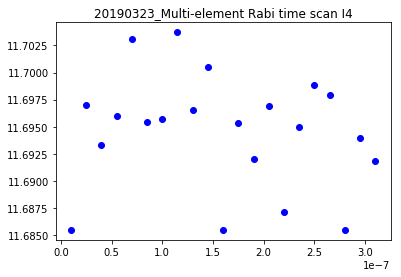

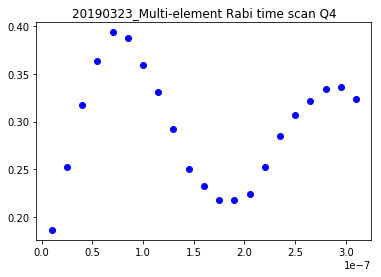

In [196]:
plt.figure()
plt.title('20190323_Multi-element Rabi time scan I4')
plt.plot(pulse_length, rabi_integrated_output_I4,'bo')
plt.figure()
plt.title('20190323_Multi-element Rabi time scan Q4')
plt.plot(pulse_length, rabi_integrated_output_Q4,'bo')

In [197]:
print(rabi_integrated_output_I4)
print(rabi_integrated_output_Q4)

[ 11.68546737  11.69699557  11.69329545  11.69600725  11.70308945
  11.69541666  11.69570394  11.70372377  11.69653533  11.70051113
  11.68547674  11.69537555  11.69200309  11.69686879  11.68709683
  11.69497439  11.69885686  11.69796947  11.68545956  11.69398382
  11.69184474]
[ 0.18647624  0.25252337  0.31776863  0.36376353  0.39370487  0.38765495
  0.35922367  0.33077779  0.29193568  0.24998955  0.23299966  0.21779185
  0.21834089  0.22380128  0.25226276  0.2848852   0.30743436  0.32193547
  0.33382887  0.33613483  0.32342711]


# Drive chevron

In [199]:
ATS_controller.awgcontrol(amp=0.2,seq='rabi_sequence_int_scan_FILE.seq')

In [136]:
pulse_length=[  1.00000000e-08,   2.50000000e-08,   4.00000000e-08,
         5.50000000e-08,   7.00000000e-08,   8.50000000e-08,
         1.00000000e-07,   1.15000000e-07,   1.30000000e-07,
         1.45000000e-07,   1.60000000e-07,   1.75000000e-07,
         1.90000000e-07,   2.05000000e-07,   2.20000000e-07,
         2.35000000e-07,   2.50000000e-07,   2.65000000e-07,
         2.80000000e-07,   2.95000000e-07,   3.10000000e-07]

In [125]:
#5 buffer - measurement.2019.03.22.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=700
integration_time=500

SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
freqs = np.linspace(6.723e9-0.04e9, 6.723e9+0.04e9, 41)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=100

chevron_integrated_output_I = np.zeros((Numer_of_elements,len(freqs)))
chevron_integrated_output_Q = np.zeros((Numer_of_elements,len(freqs)))

for iii in range(0,len(freqs)):
    SPEC.frequency.set(freqs[iii]+0.05e9)
    print(freqs[iii])
    for ii in range(0,length):
        ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
        for i in range(0,Numer_of_elements):
            chevron_integrated_output_I[i][iii]=chevron_integrated_output_I[i][iii]+ATS_Tempo[0][i]
            chevron_integrated_output_Q[i][iii]=chevron_integrated_output_Q[i][iii]+ATS_Tempo[1][i]

chevron_integrated_output_I = chevron_integrated_output_I/length
chevron_integrated_output_Q = chevron_integrated_output_Q/length

6683000000.0
6685000000.0
6687000000.0
6689000000.0
6691000000.0
6693000000.0
6695000000.0
6697000000.0
6699000000.0
6701000000.0
6703000000.0
6705000000.0
6707000000.0
6709000000.0
6711000000.0
6713000000.0
6715000000.0
6717000000.0
6719000000.0
6721000000.0
6723000000.0
6725000000.0
6727000000.0
6729000000.0
6731000000.0
6733000000.0
6735000000.0
6737000000.0
6739000000.0
6741000000.0
6743000000.0
6745000000.0
6747000000.0
6749000000.0
6751000000.0
6753000000.0
6755000000.0
6757000000.0
6759000000.0
6761000000.0
6763000000.0


In [142]:
chevron_integrated_output_I.transpose()

array([[ 11.59124161,  11.57922729,  11.57836388,  11.57868204,
         11.58525433,  11.58074521,  11.578177  ,  11.57828414,
         11.58208141,  11.58045711,  11.58586309,  11.57949251,
         11.57888819,  11.57545521,  11.57419237,  11.57492446,
         11.57286864,  11.58041687,  11.57374998,  11.58195421,
         11.57545647],
       [ 11.57563789,  11.58152801,  11.58462547,  11.58182016,
         11.57820375,  11.58011268,  11.58019062,  11.57948984,
         11.58932999,  11.57353683,  11.5740694 ,  11.57929838,
         11.57897898,  11.5759292 ,  11.58159445,  11.57598821,
         11.57578053,  11.57616931,  11.57451257,  11.57071493,
         11.57355376],
       [ 11.59433529,  11.59711813,  11.59195793,  11.58927351,
         11.58351802,  11.59647489,  11.59147676,  11.59108671,
         11.59265191,  11.59311147,  11.5860803 ,  11.59717585,
         11.58550325,  11.59039694,  11.58640377,  11.59100005,
         11.58530891,  11.59694027,  11.59428412,  11.5895

In [139]:
chevron_integrated_output_Q.transpose()

array([[ 2.94796222,  2.94885507,  2.95366413,  2.95637261,  2.9520755 ,
         2.93573676,  2.94950603,  2.94158783,  2.95221476,  2.94862994,
         2.95283527,  2.94575255,  2.94606077,  2.94766807,  2.95078887,
         2.93960913,  2.94708465,  2.95115461,  2.95407723,  2.94041094,
         2.94760012],
       [ 2.90790712,  2.90480465,  2.89180333,  2.89508533,  2.90779801,
         2.90820439,  2.89482266,  2.90158665,  2.90858929,  2.90753031,
         2.90398375,  2.90648559,  2.89760917,  2.89463955,  2.907445  ,
         2.89403925,  2.88975749,  2.90537275,  2.89195681,  2.90299587,
         2.89904903],
       [ 2.91193989,  2.93093534,  2.91746791,  2.90616023,  2.90889681,
         2.92087109,  2.92619149,  2.91699048,  2.92214361,  2.91736789,
         2.90304161,  2.91312981,  2.90967295,  2.92081302,  2.91464407,
         2.91758523,  2.90895263,  2.92090767,  2.90795019,  2.91707573,
         2.92003808],
       [ 2.90613031,  2.92546933,  2.9238216 ,  2.93031097

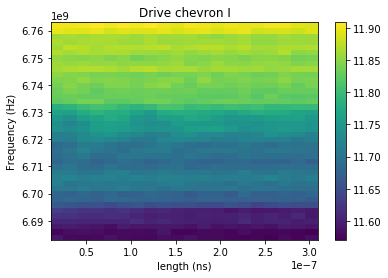

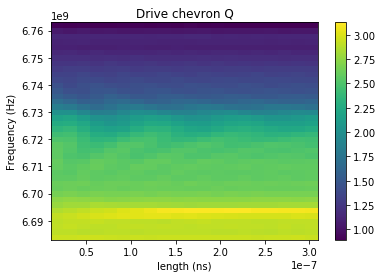

In [144]:
freqs = np.linspace(6.723e9-0.04e9, 6.723e9+0.04e9, 41)
plt.figure()
plt.title('Drive chevron I')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_integrated_output_I.transpose())
plt.colorbar()

plt.figure()
plt.title('Drive chevron Q')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_integrated_output_Q.transpose())
plt.colorbar()

In [141]:
# 5 buffer 2019.03.22.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=700
integration_time=500

SPEC.power.set(-13.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
freqs = np.linspace(6.723e9-0.04e9, 6.723e9+0.04e9, 61)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=100

chevron_integrated_output_I2 = np.zeros((Numer_of_elements,len(freqs)))
chevron_integrated_output_Q2 = np.zeros((Numer_of_elements,len(freqs)))

for iii in range(0,len(freqs)):
    SPEC.frequency.set(freqs[iii]+0.05e9)
    print(freqs[iii])
    for ii in range(0,length):
        ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
        for i in range(0,Numer_of_elements):
            chevron_integrated_output_I2[i][iii]=chevron_integrated_output_I2[i][iii]+ATS_Tempo[0][i]
            chevron_integrated_output_Q2[i][iii]=chevron_integrated_output_Q2[i][iii]+ATS_Tempo[1][i]

chevron_integrated_output_I2 = chevron_integrated_output_I2/length
chevron_integrated_output_Q2= chevron_integrated_output_Q2/length

6683000000.0
6684333333.33
6685666666.67
6687000000.0
6688333333.33
6689666666.67
6691000000.0
6692333333.33
6693666666.67
6695000000.0
6696333333.33
6697666666.67
6699000000.0
6700333333.33
6701666666.67
6703000000.0
6704333333.33
6705666666.67
6707000000.0
6708333333.33
6709666666.67
6711000000.0
6712333333.33
6713666666.67
6715000000.0
6716333333.33
6717666666.67
6719000000.0
6720333333.33
6721666666.67
6723000000.0
6724333333.33
6725666666.67
6727000000.0
6728333333.33
6729666666.67
6731000000.0
6732333333.33
6733666666.67
6735000000.0
6736333333.33
6737666666.67
6739000000.0
6740333333.33
6741666666.67
6743000000.0
6744333333.33
6745666666.67
6747000000.0
6748333333.33
6749666666.67
6751000000.0
6752333333.33
6753666666.67
6755000000.0
6756333333.33
6757666666.67
6759000000.0
6760333333.33
6761666666.67
6763000000.0


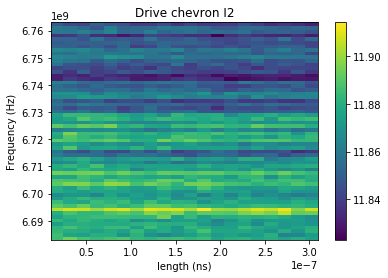

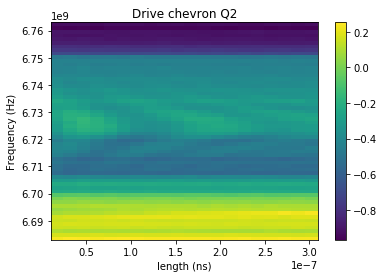

In [145]:
freqs = np.linspace(6.723e9-0.04e9, 6.723e9+0.04e9, 61)
plt.figure()
plt.title('Drive chevron I2')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_integrated_output_I2.transpose())
plt.colorbar()

plt.figure()
plt.title('Drive chevron Q2')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_integrated_output_Q2.transpose())
plt.colorbar()

In [171]:
chevron_integrated_output_I2.transpose()

array([[ 11.88570997,  11.89450279,  11.88758609, ...,  11.87974549,
         11.87473894,  11.8852089 ],
       [ 11.88570733,  11.87632196,  11.87452769, ...,  11.86439775,
         11.87293046,  11.87102311],
       [ 11.88308822,  11.87980609,  11.87902749, ...,  11.87130088,
         11.88136431,  11.87281796],
       ..., 
       [ 11.85971093,  11.85791342,  11.85324447, ...,  11.85337794,
         11.85221813,  11.84876735],
       [ 11.84884287,  11.84306765,  11.84136392, ...,  11.83496549,
         11.8310877 ,  11.83440097],
       [ 11.83620526,  11.83198925,  11.83810099, ...,  11.82518671,
         11.83252118,  11.83277888]])

In [172]:
chevron_integrated_output_Q2.transpose()

array([[ 0.23460173,  0.25367422,  0.24859806, ...,  0.2404738 ,
         0.24044194,  0.23927391],
       [ 0.17460453,  0.17679751,  0.1757016 , ...,  0.16682039,
         0.1720273 ,  0.17858029],
       [ 0.10645687,  0.09761976,  0.10360973, ...,  0.09553824,
         0.09872041,  0.09183337],
       ..., 
       [-0.95617512, -0.96051235, -0.95905205, ..., -0.96304732,
        -0.96541795, -0.95504495],
       [-0.92899751, -0.92171903, -0.92569303, ..., -0.93437803,
        -0.93037929, -0.93109535],
       [-0.90013313, -0.90888495, -0.90762725, ..., -0.90869636,
        -0.92011728, -0.9162437 ]])

In [146]:
# 5 buffer 2019.03.22.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=700
integration_time=500

SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
freqs = np.linspace(6.723e9-0.04e9, 6.723e9+0.04e9, 41)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=100

chevron_integrated_output_I3 = np.zeros((Numer_of_elements,len(freqs)))
chevron_integrated_output_Q3 = np.zeros((Numer_of_elements,len(freqs)))

for iii in range(0,len(freqs)):
    SPEC.frequency.set(freqs[iii]+0.05e9)
    print(freqs[iii])
    for ii in range(0,length):
        ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
        for i in range(0,Numer_of_elements):
            chevron_integrated_output_I3[i][iii]=chevron_integrated_output_I3[i][iii]+ATS_Tempo[0][i]
            chevron_integrated_output_Q3[i][iii]=chevron_integrated_output_Q3[i][iii]+ATS_Tempo[1][i]

chevron_integrated_output_I3 = chevron_integrated_output_I3/length
chevron_integrated_output_Q3= chevron_integrated_output_Q3/length

6683000000.0
6685000000.0
6687000000.0
6689000000.0
6691000000.0
6693000000.0
6695000000.0
6697000000.0
6699000000.0
6701000000.0
6703000000.0
6705000000.0
6707000000.0
6709000000.0
6711000000.0
6713000000.0
6715000000.0
6717000000.0
6719000000.0
6721000000.0
6723000000.0
6725000000.0
6727000000.0
6729000000.0
6731000000.0
6733000000.0
6735000000.0
6737000000.0
6739000000.0
6741000000.0
6743000000.0
6745000000.0
6747000000.0
6749000000.0
6751000000.0
6753000000.0
6755000000.0
6757000000.0
6759000000.0
6761000000.0
6763000000.0


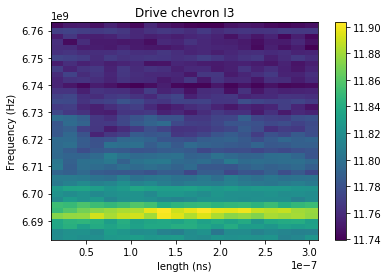

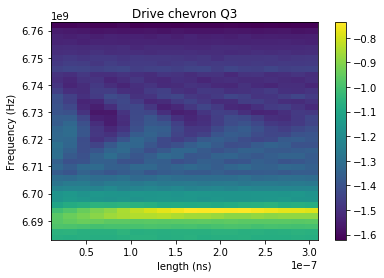

In [147]:
freqs = np.linspace(6.723e9-0.04e9, 6.723e9+0.04e9, 41)
plt.figure()
plt.title('Drive chevron I3')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_integrated_output_I3.transpose())
plt.colorbar()

plt.figure()
plt.title('Drive chevron Q3')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_integrated_output_Q3.transpose())
plt.colorbar()

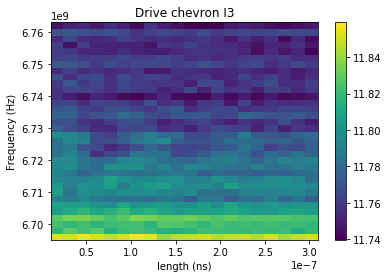

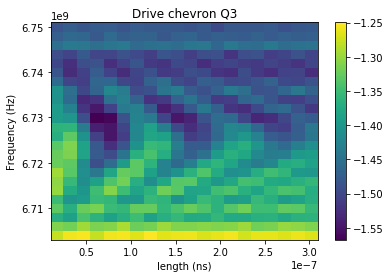

In [152]:
freqs = np.linspace(6.723e9-0.04e9, 6.723e9+0.04e9, 41)
plt.figure()
plt.title('Drive chevron I3')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs[6:],chevron_integrated_output_I3.transpose()[6:])
plt.colorbar()

plt.figure()
plt.title('Drive chevron Q3')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs[10:35],chevron_integrated_output_Q3.transpose()[10:35])
plt.colorbar()

In [173]:
chevron_integrated_output_I3.transpose()

array([[ 11.81869733,  11.8224535 ,  11.82000421,  11.82032075,
         11.82705725,  11.82817945,  11.8302469 ,  11.82560376,
         11.82722193,  11.82792153,  11.81952971,  11.81750605,
         11.82431537,  11.82089975,  11.82265743,  11.82157222,
         11.82425741,  11.81216363,  11.81520853,  11.82475911,
         11.81502692],
       [ 11.81820441,  11.82165306,  11.82266575,  11.81751938,
         11.82932365,  11.82583517,  11.81941454,  11.82071989,
         11.81138819,  11.80931235,  11.81853143,  11.82254625,
         11.80401676,  11.81894217,  11.81880611,  11.81194557,
         11.81676541,  11.81435945,  11.81106549,  11.81175399,
         11.80965679],
       [ 11.83646569,  11.84298051,  11.83212493,  11.83938025,
         11.83452225,  11.83904195,  11.83281481,  11.83797883,
         11.83806379,  11.84152236,  11.84164101,  11.83644292,
         11.83080295,  11.83945275,  11.82904919,  11.82988847,
         11.82550804,  11.83294607,  11.82982281,  11.8331

In [174]:
chevron_integrated_output_Q3.transpose()

array([[-1.06508973, -1.07479635, -1.06660285, -1.07188649, -1.0684828 ,
        -1.06450511, -1.06104823, -1.06133327, -1.06954881, -1.06667873,
        -1.06133043, -1.07511323, -1.06774052, -1.06796039, -1.06462057,
        -1.07441315, -1.07410602, -1.07430607, -1.06830839, -1.07049619,
        -1.07230079],
       [-1.05612949, -1.05455959, -1.06288002, -1.06422957, -1.06188723,
        -1.04777894, -1.06575801, -1.06283562, -1.06557781, -1.0633391 ,
        -1.06167867, -1.06173115, -1.05677753, -1.05794764, -1.06311949,
        -1.05969245, -1.06805758, -1.06467903, -1.05693502, -1.05836866,
        -1.06529245],
       [-0.98555168, -0.98753139, -0.99372249, -1.00248337, -0.99323828,
        -0.9955966 , -0.9952257 , -0.98612359, -0.99169104, -0.99786896,
        -0.99532804, -1.00218959, -0.99259819, -0.98891485, -0.99034737,
        -1.0002731 , -0.99392851, -0.99819427, -1.00081743, -0.99725078,
        -0.99173359],
       [-0.97000815, -0.95328173, -0.93991114, -0.94571899

In [153]:
# 5 buffer .2019.03.23.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=700
integration_time=500

SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
freqs = np.linspace(6.723e9-0.02e9, 6.723e9+0.02e9, 41)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=100

chevron_integrated_output_I4 = np.zeros((Numer_of_elements,len(freqs)))
chevron_integrated_output_Q4 = np.zeros((Numer_of_elements,len(freqs)))

for iii in range(0,len(freqs)):
    SPEC.frequency.set(freqs[iii]+0.05e9)
    print(freqs[iii])
    for ii in range(0,length):
        ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
        for i in range(0,Numer_of_elements):
            chevron_integrated_output_I4[i][iii]=chevron_integrated_output_I4[i][iii]+ATS_Tempo[0][i]
            chevron_integrated_output_Q4[i][iii]=chevron_integrated_output_Q4[i][iii]+ATS_Tempo[1][i]
 
chevron_integrated_output_I4= chevron_integrated_output_I4/length
chevron_integrated_output_Q4= chevron_integrated_output_Q4/length

6703000000.0
6704000000.0
6705000000.0
6706000000.0
6707000000.0
6708000000.0
6709000000.0
6710000000.0
6711000000.0
6712000000.0
6713000000.0
6714000000.0
6715000000.0
6716000000.0
6717000000.0
6718000000.0
6719000000.0
6720000000.0
6721000000.0
6722000000.0
6723000000.0
6724000000.0
6725000000.0
6726000000.0
6727000000.0
6728000000.0
6729000000.0
6730000000.0
6731000000.0
6732000000.0
6733000000.0
6734000000.0
6735000000.0
6736000000.0
6737000000.0
6738000000.0
6739000000.0
6740000000.0
6741000000.0
6742000000.0
6743000000.0


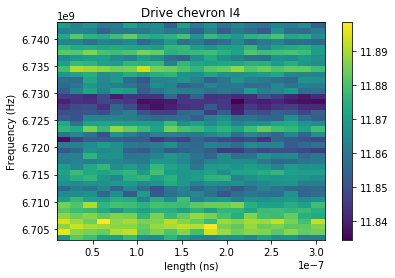

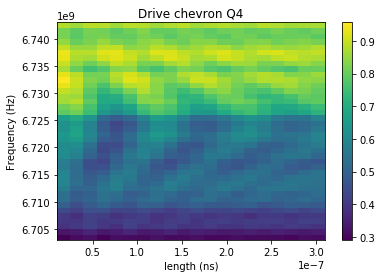

In [154]:
freqs = np.linspace(6.723e9-0.02e9, 6.723e9+0.02e9, 41)
plt.figure()
plt.title('Drive chevron I4')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_integrated_output_I4.transpose())
plt.colorbar()

plt.figure()
plt.title('Drive chevron Q4')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_integrated_output_Q4.transpose())
plt.colorbar()

In [201]:
chevron_I4_corr=np.zeros((41,21))
chevron_Q4_corr=np.zeros((41,21))
for i in range(len(freqs)):
    chevron_I4_corr[:][i]=chevron_integrated_output_I4.transpose()[:][i]/(np.sum(chevron_integrated_output_I4.transpose()[:][i])/21)
    chevron_Q4_corr[:][i]=chevron_integrated_output_Q4.transpose()[:][i]/(np.sum(chevron_integrated_output_Q4.transpose()[:][i])/21)

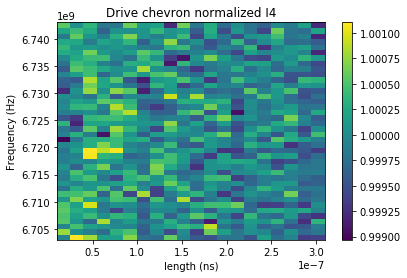

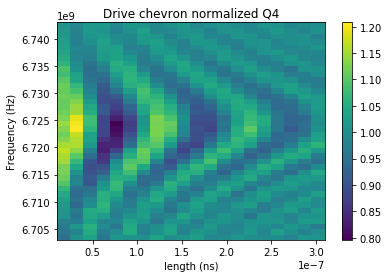

In [202]:
freqs = np.linspace(6.723e9-0.02e9, 6.723e9+0.02e9, 41)
plt.figure()
plt.title('Drive chevron normalized I4')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_I4_corr)
plt.colorbar()

plt.figure()
plt.title('Drive chevron normalized Q4')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_Q4_corr)
plt.colorbar()

In [203]:
print(chevron_I4_corr)
print(chevron_Q4_corr)

[[ 0.99992822  1.00110435  1.00080609  1.00015313  1.00015423  1.00071427
   0.99976648  0.9997151   1.00058972  0.9999266   0.99957278  0.99949582
   0.99977914  0.99980456  0.99953688  1.00017062  0.99974879  0.99992026
   0.99935902  0.99938753  1.00036642]
 [ 1.00077951  1.00003492  0.99988605  0.99972789  1.00033182  1.00049497
   0.9995824   0.9999495   0.99946912  0.99999168  0.99937954  1.00062597
   1.00016451  0.99980063  1.00001993  0.99996944  0.99961902  1.00003073
   0.99969615  0.99981964  1.00062656]
 [ 0.99994998  1.00046306  1.00018803  1.00011041  0.99997434  0.99994321
   0.9996299   1.00004662  1.00020031  1.00040544  1.00030728  1.000899
   0.99979446  0.99956493  1.00006193  0.99964712  0.99979081  0.99953123
   0.99956585  0.999868    1.0000581 ]
 [ 1.00053061  1.00007416  0.99968541  1.00083844  0.99995354  1.000145
   0.99979037  0.99983966  1.00031079  0.99989817  0.99961699  0.9991408
   1.00006186  0.99986265  1.0001377   1.00005262  1.0003525   0.99975703


In [205]:
# 5 buffer .2019.03.23.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=800
integration_time=500

SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
freqs = np.linspace(6.723e9-0.02e9, 6.723e9+0.02e9, 41)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=100

chevron_integrated_output_I5 = np.zeros((Numer_of_elements,len(freqs)))
chevron_integrated_output_Q5 = np.zeros((Numer_of_elements,len(freqs)))

for iii in range(0,len(freqs)):
    SPEC.frequency.set(freqs[iii]+0.05e9)
    print(freqs[iii])
    for ii in range(0,length):
        ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
        for i in range(0,Numer_of_elements):
            chevron_integrated_output_I5[i][ii  i]=chevron_integrated_output_I5[i][iii]+ATS_Tempo[0][i]
            chevron_integrated_output_Q5[i][iii]=chevron_integrated_output_Q5[i][iii]+ATS_Tempo[1][i]
 
chevron_integrated_output_I5 = chevron_integrated_output_I5/length
chevron_integrated_output_Q5 = chevron_integrated_output_Q5/length

6703000000.0
6704000000.0
6705000000.0
6706000000.0
6707000000.0
6708000000.0
6709000000.0
6710000000.0
6711000000.0
6712000000.0
6713000000.0
6714000000.0
6715000000.0
6716000000.0
6717000000.0
6718000000.0
6719000000.0
6720000000.0
6721000000.0
6722000000.0
6723000000.0
6724000000.0
6725000000.0
6726000000.0
6727000000.0
6728000000.0
6729000000.0
6730000000.0
6731000000.0
6732000000.0
6733000000.0
6734000000.0
6735000000.0
6736000000.0
6737000000.0
6738000000.0
6739000000.0
6740000000.0
6741000000.0
6742000000.0
6743000000.0


In [206]:
chevron_I5_corr=np.zeros((41,21))
chevron_Q5_corr=np.zeros((41,21))
for i in range(len(freqs)):
    chevron_I5_corr[:][i]=chevron_integrated_output_I5.transpose()[:][i]/(np.sum(chevron_integrated_output_I5.transpose()[:][i])/21)
    chevron_Q5_corr[:][i]=chevron_integrated_output_Q5.transpose()[:][i]/(np.sum(chevron_integrated_output_Q5.transpose()[:][i])/21)

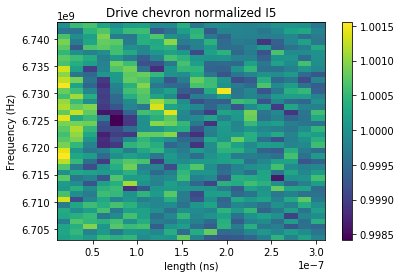

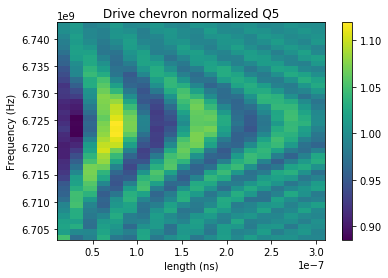

In [207]:
freqs = np.linspace(6.723e9-0.02e9, 6.723e9+0.02e9, 41)
plt.figure()
plt.title('Drive chevron normalized I5')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_I5_corr)
plt.colorbar()

plt.figure()
plt.title('Drive chevron normalized Q5')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_Q5_corr)
plt.colorbar()

In [13]:
# 5 buffer .2019.03.24.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=800
integration_time=500

SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
freqs = np.linspace(6.723e9-0.04e9, 6.723e9+0.04e9, 81)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=100

chevron_integrated_output_I5 = np.zeros((Numer_of_elements,len(freqs)))
chevron_integrated_output_Q5 = np.zeros((Numer_of_elements,len(freqs)))

for iii in range(0,len(freqs)):
    SPEC.frequency.set(freqs[iii]+0.05e9)
    print(freqs[iii])
    for ii in range(0,length):
        ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
        for i in range(0,Numer_of_elements):
            chevron_integrated_output_I5[i][iii]=chevron_integrated_output_I5[i][iii]+ATS_Tempo[0][i]
            chevron_integrated_output_Q5[i][iii]=chevron_integrated_output_Q5[i][iii]+ATS_Tempo[1][i]
 
chevron_integrated_output_I5 = chevron_integrated_output_I5/length
chevron_integrated_output_Q5 = chevron_integrated_output_Q5/length

6683000000.0
6684000000.0
6685000000.0
6686000000.0
6687000000.0
6688000000.0
6689000000.0
6690000000.0
6691000000.0
6692000000.0
6693000000.0
6694000000.0
6695000000.0
6696000000.0
6697000000.0
6698000000.0
6699000000.0
6700000000.0
6701000000.0
6702000000.0
6703000000.0
6704000000.0
6705000000.0
6706000000.0
6707000000.0
6708000000.0
6709000000.0
6710000000.0
6711000000.0
6712000000.0
6713000000.0
6714000000.0
6715000000.0
6716000000.0
6717000000.0
6718000000.0
6719000000.0
6720000000.0
6721000000.0
6722000000.0
6723000000.0
6724000000.0
6725000000.0
6726000000.0
6727000000.0
6728000000.0
6729000000.0
6730000000.0
6731000000.0
6732000000.0
6733000000.0
6734000000.0
6735000000.0
6736000000.0
6737000000.0
6738000000.0
6739000000.0
6740000000.0
6741000000.0
6742000000.0
6743000000.0
6744000000.0
6745000000.0
6746000000.0
6747000000.0
6748000000.0
6749000000.0
6750000000.0
6751000000.0
6752000000.0
6753000000.0
6754000000.0
6755000000.0
6756000000.0
6757000000.0
6758000000.0
6759000000.0

In [ ]:
chevron_I5_corr=np.zeros((81,21))
chevron_Q5_corr=np.zeros((81,21))
for i in range(len(freqs)):
    chevron_I5_corr[:][i]=chevron_integrated_output_I5.transpose()[:][i]/(np.sum(chevron_integrated_output_I5.transpose()[:][i])/21)
    chevron_Q5_corr[:][i]=chevron_integrated_output_Q5.transpose()[:][i]/(np.sum(chevron_integrated_output_Q5.transpose()[:][i])/21)

In [ ]:
freqs = np.linspace(6.723e9-0.04e9, 6.723e9+0.04e9, 81)
plt.figure()
plt.title('Drive chevron normalized I5')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_I5_corr)
plt.colorbar()

plt.figure()
plt.title('Drive chevron normalized Q5')
plt.xlabel('length (ns)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(pulse_length,freqs,chevron_Q5_corr)
plt.colorbar()